In [82]:
import requests
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine 
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Extracting Data

In [5]:
%time df = dd.read_csv("C:\\EZOIC_ASSESSMENT\\311_Service_Requests_from_2010_to_Present.csv")

Wall time: 190 ms


In [6]:
pd.set_option('display.max_rows',100)
print(df.dtypes)

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                        int64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                          float64
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                   

In [7]:
#print(df.head())

#### Some of the datatypes are wrong 

### The data types were initialized incorrectly for some of the columns

String columns should be intialized as 'Object' instead of 'float' we need to convert it in dataframe as below and deal with null values too

In [8]:
%time df1 = dd.read_csv("C:\\EZOIC_ASSESSMENT\\311_Service_Requests_from_2010_to_Present.csv",dtype={'Incident Zip':'object','Vehicle Type': 'object','Bridge Highway Direction': 'object','Bridge Highway Name': 'object','Bridge Highway Segment': 'object','Landmark': 'object','Road Ramp': 'object','Taxi Company Borough': 'object','X Coordinate (State Plane)':'float64','Y Coordinate (State Plane)':'float64'})

Wall time: 193 ms


In [9]:
df1.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                       object
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                           object
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                   

Checking Missing Values on new dataframe

#### MISSING VALUES

In [10]:
missing_values = df1.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Address Type                  int64
Y Coordinate (State Plane)      ...
dtype: int64
Dask Name: dataframe-sum-agg, 996 tasks

#### MISSING VALUES PERCENTAGE

In [11]:
missing_count = ((missing_values / df1.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Address Type                  float64
Y Coordinate (State Plane)        ...
dtype: float64
Dask Name: mul, 1397 tasks

In [12]:
with ProgressBar():
    missing_count_pct = missing_count.compute()
missing_count_pct

[###########                             ] | 28% Completed | 56.5s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############                           ] | 34% Completed |  1min  5.0s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##############                          ] | 36% Completed |  1min 12.2s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 77% Completed |  2min 32.9s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[################################        ] | 80% Completed |  2min 38.8s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (18,20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed |  3min  7.5s


Unique Key                         0.000000
Created Date                       0.000000
Closed Date                        2.690807
Agency                             0.000000
Agency Name                        0.000000
Complaint Type                     0.000000
Descriptor                         1.131278
Location Type                     24.963603
Incident Zip                       5.830547
Incident Address                  18.792759
Street Name                       18.798970
Cross Street 1                    33.027832
Cross Street 2                    33.381905
Intersection Street 1             81.865365
Intersection Street 2             81.898895
Address Type                       6.930854
City                               6.117111
Landmark                          96.974592
Facility Type                     75.266947
Status                             0.000000
Due Date                          61.175572
Resolution Description             2.227937
Resolution Action Updated Date  

1. Now here It is impotrant to remove those columns whose missing value percentage is >60.
2. We cant do operations/trainel model to predict a column whose 60 % of values are missing
3. Borough has 0% values missing 2nd question can be answered but before that check for innacurate characters (Incident Zip)

In [218]:
columns_to_drop = missing_count_pct[missing_count_pct > 60].index
with ProgressBar():
    df_dropped = df1.drop(columns_to_drop, axis=1).persist()

[###########                             ] | 28% Completed | 51.0s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############                           ] | 34% Completed | 58.3s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##############                          ] | 37% Completed |  1min  5.2s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 79% Completed |  2min 17.2s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[################################        ] | 80% Completed |  2min 21.6s

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:252: DtypeWarning: Columns (18,20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed |  2min 46.9s


In [125]:
df_dropped.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                       object
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Address Type                       object
City                               object
Status                             object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                    object
BBL                               float64
Borough                            object
X Coordinate (State Plane)        float64
Y Coordinate (State Plane)        float64
Open Data Channel Type            

In [126]:
df_dropped.tail()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location
83771,27842649,04/14/2014 08:48:00 AM,04/21/2014 04:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10006,34 WEST STREET,...,1.000168e+09,MANHATTAN,979814.0,196782.0,ONLINE,Unspecified,MANHATTAN,40.706797,-74.016000,"(40.70679678045445, -74.01599985239896)"
83772,27842650,04/14/2014 11:02:00 PM,04/15/2014 08:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,10036,NaN,...,NaN,MANHATTAN,988913.0,214759.0,PHONE,Unspecified,MANHATTAN,40.756139,-73.983169,"(40.75613911897527, -73.98316894112523)"
83773,27842652,04/14/2014 12:21:00 PM,04/20/2014 06:30:00 PM,DEP,Department of Environmental Protection,Sewer,Defective/Missing Curb Piece (SC4),NaN,11228,NaN,...,NaN,BROOKLYN,984518.0,164775.0,PHONE,Unspecified,BROOKLYN,40.618946,-73.999035,"(40.61894576099455, -73.99903464452899)"
83774,27842653,04/14/2014 01:26:00 PM,04/18/2014 10:45:00 AM,DEP,Department of Environmental Protection,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),NaN,10469,2305 ELY AVENUE,...,2.044220e+09,BRONX,1031185.0,252600.0,PHONE,Unspecified,BRONX,40.859879,-73.830324,"(40.859878648052884, -73.83032415755054)"
83775,27842654,04/14/2014 09:06:00 AM,04/14/2014 09:34:00 AM,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),NaN,10472,1691 EAST 174 STREET,...,2.038920e+09,BRONX,1019600.0,243325.0,ONLINE,Unspecified,BRONX,40.834476,-73.872254,"(40.83447552234542, -73.87225419756115)"


In [127]:
a = df1.shape
print("Before dropped Columns",a[0].compute(),a[1])
a = df_dropped.shape
print("After dropped Columns",a[0].compute(),a[1])

Before dropped Columns 22314047 41
After dropped Columns 22314047 29


#### 1. How many incidents were opened in each year (beginning with 2010)?
#### 2. Which borough has the most incidents?

To Answer 1 and 2 and Questions
1. Check Unique Key is not repeating (As Each Unique Key represents a service request)
2. Convert Craeted Date (Incident is craeted on thsi date) look for year variable and count UniqueKeys

In [128]:
df_incidents = pd.read_csv(
    "C:\\EZOIC_ASSESSMENT\\311_Service_Requests_from_2010_to_Present.csv",
    usecols = [
        'Unique Key',
        'Created Date',
        'Closed Date',
        'Borough',
        'City'
    ]
)

In [129]:
df_incidents["Created Date"] = pd.to_datetime(
    df_incidents["Created Date"],
    format = "%m/%d/%Y %H:%M:%S %p"   
)

In [130]:
df_incidents_year = df_incidents[df_incidents['Created Date'].dt.year>2009]
df_incidents_year['Year'] = df_incidents['Created Date'].dt.year
df_incidents_year

,Unique Key,Created Date,Closed Date,City,Borough,Year
0,27842655,2014-04-14 02:42:00,08/20/2014 10:55:00 AM,STATEN ISLAND,STATEN ISLAND,2014
1,27842656,2014-04-14 11:04:00,05/01/2015 02:00:00 PM,BRONX,BRONX,2014
2,27842659,2014-04-14 01:27:00,04/14/2014 03:03:00 PM,Queens Village,QUEENS,2014
3,27842660,2014-04-14 12:51:00,04/14/2014 02:15:00 PM,STATEN ISLAND,STATEN ISLAND,2014
4,27842663,2014-04-14 12:35:00,04/14/2014 02:28:00 PM,Jamaica,QUEENS,2014
5,27842665,2014-04-14 09:11:00,04/17/2014 01:00:00 PM,STATEN ISLAND,STATEN ISLAND,2014
6,27842668,2014-04-14 12:35:00,04/15/2014 09:35:00 AM,BROOKLYN,BROOKLYN,2014
7,27842670,2014-04-14 08:16:00,04/24/2014 11:15:00 AM,NEW YORK,MANHATTAN,2014
8,27842671,2014-04-14 12:29:00,04/14/2014 07:10:00 PM,STATEN ISLAND,STATEN ISLAND,2014
9,27842672,2014-04-14 01:11:00,04/14/2014 07:00:00 AM,East Elmhurst,QUEENS,2014


In [131]:
k = pd.DataFrame(df_incidents_year[['Unique Key']].groupby(df_incidents_year['Year']).agg(['count'])).reset_index()
k
#k.info()

,Year,Unique Key
,,count
0,2010,2031813
1,2011,1961598
2,2012,1796172
3,2013,1839974
4,2014,2114000
5,2015,2300760
6,2016,2391426
7,2017,2491969
8,2018,2747950


In [132]:
k.to_csv("C:\\EZOIC_ASSESSMENT\\IncidentTrendByYear.csv",index=False)

In [133]:
l = pd.DataFrame(df_incidents_year[['Unique Key']].groupby(df_incidents_year['Borough']).agg(['count'])).reset_index()
l

,Borough,Unique Key
,,count
0,BRONX,3891635
1,BROOKLYN,6642260
2,MANHATTAN,4345863
3,QUEENS,5103254
4,STATEN ISLAND,1119291
5,Unspecified,1211744


In [134]:
l.to_csv("C:\\EZOIC_ASSESSMENT\\BoroughIncidents.csv",index=False)

### Brooklyn has more Incidents

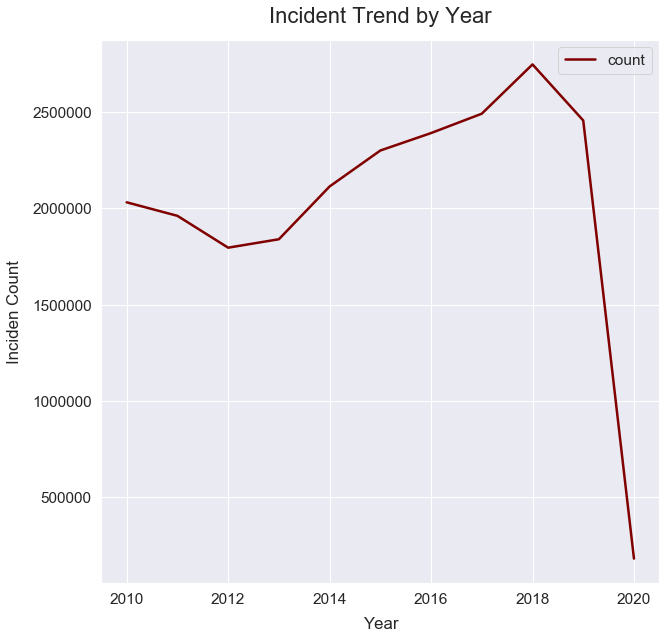

In [135]:
sns.set(font_scale=1.4)
k.set_index('Year')['Unique Key'].plot(figsize=(10, 10), linewidth=2.5, color='maroon')
plt.xlabel("Year", labelpad=10)
plt.ylabel("Inciden Count", labelpad=10)
plt.title("Incident Trend by Year", y=1.02, fontsize=22);

In [136]:
#df_incidents_year.groupby('Year')['Unique Key'].agg(['sum','count'])['count']

In [137]:
print("Divisons",df_dropped.divisions)
print("Partitions",df_dropped.npartitions)

Divisons (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 

#### Things to Look into
1. Incident ZipCode
2. Unspecified borough
3. Data Type of Columns associated with date


### Zip

In [138]:
df_dropped.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location
0,27842655,04/14/2014 02:42:00 PM,08/20/2014 10:55:00 AM,DEP,Department of Environmental Protection,Water System,Defective Street Cut (WZZ1),NaN,10303,2560 RICHMOND TERRACE,...,5.011500e+09,STATEN ISLAND,943586.0,171622.0,ONLINE,Unspecified,STATEN ISLAND,40.637646,-74.146516,"(40.63764599489574, -74.14651579795446)"
1,27842656,04/14/2014 11:04:00 AM,05/01/2015 02:00:00 PM,DEP,Department of Environmental Protection,Sewer,Catch Basin Sunken/Damaged/Raised (SC1),NaN,10460,880 EAST TREMONT AVENUE,...,2.029600e+09,BRONX,1015835.0,246349.0,PHONE,Unspecified,BRONX,40.842790,-73.885846,"(40.842789784424255, -73.88584568128475)"
2,27842659,04/14/2014 01:27:00 PM,04/14/2014 03:03:00 PM,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),NaN,11428,220-05 93 AVENUE,...,4.107330e+09,QUEENS,1057568.0,202719.0,PHONE,Unspecified,QUEENS,40.722790,-73.735491,"(40.722789705537885, -73.73549132976942)"
3,27842660,04/14/2014 12:51:00 PM,04/14/2014 02:15:00 PM,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),NaN,10301,128 BENZIGER AVENUE,...,5.000380e+09,STATEN ISLAND,961206.0,172373.0,PHONE,Unspecified,STATEN ISLAND,40.639771,-74.083032,"(40.63977069540825, -74.08303207959038)"
4,27842663,04/14/2014 12:35:00 PM,04/14/2014 02:28:00 PM,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),NaN,11434,132-41 BENNETT COURT,...,4.129840e+09,QUEENS,1050264.0,186435.0,PHONE,Unspecified,QUEENS,40.678152,-73.762001,"(40.678151620421175, -73.76200138093122)"


In [139]:
df_dropped.shape

(Delayed('int-f13bc3e5-2d15-4a36-a65a-e3532d849aae'), 29)

In [140]:
df_dropped['Incident Zip'].unique().compute()


0            10303
1            10460
2            11428
3            10301
4            11434
5            11210
6            10017
7            10312
8            11370
9            11355
10           10467
11           10304
12           11357
13           11226
14           11214
15           10009
16           10003
17           11217
18           11201
19           11236
20           11211
21           11378
22           10162
23           11429
24           11354
25           11375
26           11235
27           10463
28           11432
29           10013
30           10306
31           11436
32           11231
33           10472
34           11420
35           11414
36           10011
37           11377
38           11360
39           11101
40           11423
41           11218
42           10465
43           11204
44           11232
45           11249
46           10464
47           11361
48           11229
49           11220
           ...    
2769         84119
2770        

In [141]:
#NY Zip codes : https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
def clean_zip(zip_code):
    try:
        zip_code = int(float(zip_code))
    except:
        try:
            zip_code = int(float(zip_code.split('-')[0]))
        except:
            return np.nan
    if zip_code < 10000 or zip_code > 19999:
        return np.nan
    else:
        return str(zip_code)

In [142]:
df_dropped['Incident Zip'] = df_dropped['Incident Zip'].apply(clean_zip)

C:\Users\pavani.nrusimhadevar\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\core.py:2259: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [143]:
### Are there any null values
df_dropped['Incident Zip'].isnull().values.any().compute()

True

#### Remove all those columns who zip code is null or nan

In [144]:
df_dropped = df_dropped[df_dropped['Incident Zip'].notnull()]

In [145]:
a = df_dropped.shape
print("After Zip Clean",a[0].compute(),a[1])

After Zip Clean 21006138 29


#### Data Type of Date Columns

In [146]:
df_dropped.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                      float64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Address Type                       object
City                               object
Status                             object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                    object
BBL                               float64
Borough                            object
X Coordinate (State Plane)        float64
Y Coordinate (State Plane)        float64
Open Data Channel Type            

In [219]:
df_dropped["Created Date"].head(10)

0    04/14/2014 02:42:00 PM
1    04/14/2014 11:04:00 AM
2    04/14/2014 01:27:00 PM
3    04/14/2014 12:51:00 PM
4    04/14/2014 12:35:00 PM
5    04/14/2014 09:11:00 PM
6    04/14/2014 12:35:00 PM
7    04/14/2014 08:16:00 AM
8    04/14/2014 12:29:00 PM
9    04/14/2014 01:11:00 AM
Name: Created Date, dtype: object

In [220]:
df_dropped["Created Date"] = dd.to_datetime(df_dropped["Created Date"],format = "%m/%d/%Y %I:%M:%S %p",errors = 'coerce')

In [221]:
df_dropped["Created Date"].head(30)

0    2014-04-14 14:42:00
1    2014-04-14 11:04:00
2    2014-04-14 13:27:00
3    2014-04-14 12:51:00
4    2014-04-14 12:35:00
5    2014-04-14 21:11:00
6    2014-04-14 12:35:00
7    2014-04-14 08:16:00
8    2014-04-14 12:29:00
9    2014-04-14 01:11:00
10   2014-04-14 07:43:00
11   2014-04-14 09:32:00
12   2014-04-14 11:59:00
13   2014-04-14 15:40:00
14   2014-04-14 12:13:00
15   2014-04-14 18:48:00
16   2014-04-14 13:21:00
17   2014-04-14 12:32:00
18   2014-04-14 11:38:00
19   2014-04-14 15:13:00
20   2014-04-14 00:00:00
21   2014-04-14 15:11:00
22   2014-04-14 14:41:00
23   2014-04-14 12:31:00
24   2014-04-14 07:27:00
25   2014-04-14 00:00:00
26   2014-04-14 08:46:01
27   2014-04-11 09:18:32
28   2014-04-14 00:00:00
29   2014-04-14 10:39:59
Name: Created Date, dtype: datetime64[ns]

In [222]:
df_dropped["Closed Date"] = dd.to_datetime(df_dropped["Closed Date"],format = "%m/%d/%Y %I:%M:%S %p",errors = 'coerce')

In [223]:
df_dropped["Closed Date"].head()

0   2014-08-20 10:55:00
1   2015-05-01 14:00:00
2   2014-04-14 15:03:00
3   2014-04-14 14:15:00
4   2014-04-14 14:28:00
Name: Closed Date, dtype: datetime64[ns]

In [224]:
df_dropped["Resolution Action Updated Date"].head()

0    08/20/2014 10:55:00 AM
1    05/01/2015 02:00:00 PM
2    04/14/2014 03:03:00 PM
3    04/14/2014 02:15:00 PM
4    04/14/2014 02:28:00 PM
Name: Resolution Action Updated Date, dtype: object

In [225]:
#Resolution Action Updated Date
df_dropped["Resolution Action Updated Date"] = dd.to_datetime(df_dropped["Resolution Action Updated Date"],format = "%m/%d/%Y %I:%M:%S %p",errors = 'coerce')

In [226]:
df_dropped["Resolution Action Updated Date"].head()

0   2014-08-20 10:55:00
1   2015-05-01 14:00:00
2   2014-04-14 15:03:00
3   2014-04-14 14:15:00
4   2014-04-14 14:28:00
Name: Resolution Action Updated Date, dtype: datetime64[ns]

In [227]:
df_dropped['Total_Time'] =  (df_dropped['Closed Date']- df_dropped['Created Date']).dt.days

In [228]:
df_dropped['Resolution_Time'] =  (df_dropped['Resolution Action Updated Date']- df_dropped['Created Date']).dt.days

In [229]:
df_dropped['Total_Time'].head(10)

0    127.0
1    382.0
2      0.0
3      0.0
4      0.0
5      2.0
6      0.0
7     10.0
8      0.0
9      0.0
Name: Total_Time, dtype: float64

In [230]:
df_dropped['Resolution_Time'].head(10)

0    127.0
1    382.0
2      0.0
3      0.0
4      0.0
5      2.0
6      0.0
7     10.0
8      0.0
9      0.0
Name: Resolution_Time, dtype: float64

##### Closed Date > Created Date always so something is wrong in the incidents otherwise
##### negative (WRONG!!) has to eliminated

In [231]:
df_dropped.dtypes

Unique Key                                 int64
Created Date                      datetime64[ns]
Closed Date                       datetime64[ns]
Agency                                    object
Agency Name                               object
Complaint Type                            object
Descriptor                                object
Location Type                             object
Incident Zip                              object
Incident Address                          object
Street Name                               object
Cross Street 1                            object
Cross Street 2                            object
Address Type                              object
City                                      object
Status                                    object
Resolution Description                    object
Resolution Action Updated Date    datetime64[ns]
Community Board                           object
BBL                                      float64
Borough             

In [232]:
df_dropped[df_dropped['Total_Time']<0].head(3)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time
39,27842719,2014-04-14 10:02:00,2014-04-11 10:02:00,DOT,Department of Transportation,Street Light Condition,Fixture/Luminaire Door Open,NaN,11231,NaN,...,980851.0,186934.0,UNKNOWN,Unspecified,BROOKLYN,40.679767,-74.012255,"(40.67976675817528, -74.01225461123266)",-3.0,-3.0
54,27842739,2014-04-12 13:46:45,2014-04-12 12:35:00,DOT,Department of Transportation,Street Condition,Pothole,NaN,11232,2 AVENUE,...,981607.0,178360.0,UNKNOWN,Unspecified,BROOKLYN,40.656233,-74.009526,"(40.656233297034625, -74.00952559923958)",-1.0,-1.0
77,27842788,2014-04-14 16:39:00,2014-04-11 16:39:00,DOT,Department of Transportation,Street Light Condition,Street Light Dayburning,NaN,10462,NaN,...,1026117.0,243564.0,UNKNOWN,Unspecified,BRONX,40.835103,-73.848702,"(40.83510301726856, -73.84870198819223)",-3.0,-3.0


In [233]:
df_dropped[df_dropped['Resolution_Time']<0].head(3)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time
39,27842719,2014-04-14 10:02:00,2014-04-11 10:02:00,DOT,Department of Transportation,Street Light Condition,Fixture/Luminaire Door Open,NaN,11231,NaN,...,980851.0,186934.0,UNKNOWN,Unspecified,BROOKLYN,40.679767,-74.012255,"(40.67976675817528, -74.01225461123266)",-3.0,-3.0
54,27842739,2014-04-12 13:46:45,2014-04-12 12:35:00,DOT,Department of Transportation,Street Condition,Pothole,NaN,11232,2 AVENUE,...,981607.0,178360.0,UNKNOWN,Unspecified,BROOKLYN,40.656233,-74.009526,"(40.656233297034625, -74.00952559923958)",-1.0,-1.0
77,27842788,2014-04-14 16:39:00,2014-04-11 16:39:00,DOT,Department of Transportation,Street Light Condition,Street Light Dayburning,NaN,10462,NaN,...,1026117.0,243564.0,UNKNOWN,Unspecified,BRONX,40.835103,-73.848702,"(40.83510301726856, -73.84870198819223)",-3.0,-3.0


In [213]:
df_columns = list(df_dropped.columns)
df_dropped[df_columns].count().compute()

Unique Key                        22314047
Created Date                      22314047
Closed Date                       21713618
Agency                            22314047
Agency Name                       22314047
Complaint Type                    22314047
Descriptor                        22061613
Location Type                     16743657
Incident Zip                      21013016
Incident Address                  18120622
Street Name                       18119236
Cross Street 1                    14944201
Cross Street 2                    14865193
Address Type                      20767493
City                              20949072
Status                            22314047
Resolution Description            21816904
Resolution Action Updated Date    22021160
Community Board                   22314047
BBL                               17190052
Borough                           22314047
X Coordinate (State Plane)        20284404
Y Coordinate (State Plane)        20284404
Open Data C

In [234]:
# Remove all data from df that have negative Processing Time
df_dropped = df_dropped[df_dropped['Total_Time']>=0]

In [235]:
df_dropped = df_dropped[df_dropped['Resolution_Time']>=0]

In [236]:
df_columns = list(df_dropped.columns)
df_dropped[df_columns].count().compute()

Unique Key                        20755436
Created Date                      20755436
Closed Date                       20755436
Agency                            20755436
Agency Name                       20755436
Complaint Type                    20755436
Descriptor                        20514026
Location Type                     16063792
Incident Zip                      19905390
Incident Address                  17256635
Street Name                       17255343
Cross Street 1                    14161669
Cross Street 2                    14127062
Address Type                      19467108
City                              19845735
Status                            20755436
Resolution Description            20332700
Resolution Action Updated Date    20755436
Community Board                   20755436
BBL                               16522751
Borough                           20755436
X Coordinate (State Plane)        19188402
Y Coordinate (State Plane)        19188402
Open Data C

##### Boroughs ---> Unspecified ?

###### Lets Create Year Month Day of the week for each incident in our table (They can be later used in the model to see the patterens for holidays seasons weekends)

#### Complaints can be of Various Types 

Ex:We cannot say a Vehicle Type for a complaint replated to home

In [ ]:
with ProgressBar():
    print(df_dropped['Agency'].unique().head(1000))

In [ ]:
with ProgressBar():
    print(df_dropped['Agency Name'].unique().head(1000))

1. Comaplaints fall under on the above 31 agencies so the type of compalint can be categorized according to agency types
2. Each may consists of different departments and Each City has different Agencies

This to look into ...

1. My Complaint Type Can be various types

2. Depending on the The type of compalint we need to evealue variables

3. Need to check if deleted columns are necessary (as they might be minor)


In [ ]:
%store